In [39]:
# Wanted a full set of Ages for all respondents
# This being human data, there's a lot of discrepancies
# this script ditches "obviously wrong" entries and then curve fits Age at W1 from the various wave age variables
# (that appears to be what the standardised BES "Age" variable is trying to do)
# There's still 637 respondents left with no Age information - I think (from prior info) those entries might be bunk
# but still, used a very blind xgboost model to infer ages to fill in those blanks
# inferred age for all waves that have an age variable saved
# also saved Age, ageGroup, equalLengthAge groups, equalDensityAge groups (6 gps, 12 gps)



In [43]:
%%time
dataset_name = "W19_comb"
df_list = [ "BES_Panel" ]

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}

if "id" in BES_Panel.columns:
    BES_Panel = BES_Panel.set_index("id").sort_index()

(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
# pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_valuesW19"+".csv")
pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')

Toggle code

var_type (7911, 14)
Wall time: 26.3 s


In [44]:
BES_Panel = pd.read_pickle("..\\BES_analysis_data\\"+"W19_comb"+os.sep+"BES_Panelv02",compression='zip')
BES_Panel = BES_Panel.set_index("id")
BES_Panel = BES_Panel.sort_index()

In [45]:
BES_reduced_with_na = pd.read_pickle("E:\\BES_analysis_data"+os.sep+"BES_reduced_with_na.zip",compression='zip')
BES_reduced_with_na = BES_reduced_with_na.loc[BES_Panel.index].sort_index()

In [1]:
# import warnings
# warnings.filterwarnings('ignore')

# from IPython.display import display
# from IPython.display import HTML
# import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# # This line will hide code by default when the notebook is exported as HTML
# di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# # This line will add a button to toggle visibility of code blocks, for use with the HTML export version
# di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

# %matplotlib inline

# import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
# import pickle, os, gc, re

# sns.set();
# sns.set_palette("colorblind")

# from IPython.display import display, display_html, HTML
# from IPython.core.debugger import set_trace
# # plt.rcParams["axes.grid"] = False

# import Jupyter_module_loader
# from utility import *
# import gaussian_kde

# import warnings
# warnings.filterwarnings('ignore')

# import holoviews as hv
# from holoviews import opts

# encoding = "ISO-8859-1"

# # you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# # %matplotlib inline
# (BES_code_folder, BES_small_data_files, BES_data_folder,
#  BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

# global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
# data_subfolder = BES_data_folder + dataset_name + os.sep

# (manifest, dataset_filename, dataset_description, dataset_citation,
#  dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

# for df in df_list:
#     if df=="BES_Panel":
#         globals()[df]  = pd.read_pickle(data_subfolder + dataset_filename.replace('.dta','.zip'),compression='zip')
#     else:
#         globals()[df]  = pd.read_pickle(data_subfolder + df + '.zip',compression='zip' )
#         globals()[df].replace(-1,np.nan,inplace=True)
  
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# # get full set of inferred "cross wave" auth-lib/left-right values and ages
# pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")
# pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )

In [4]:
match(BES_Panel,"Age|age")

ageW1       30589
ageW7       30895
ageW8       33502
ageW9       30036
ageW11      30956
ageW12      34394
ageW13      31136
ageW14      31063
ageW16      37959
ageW17      34366
ageW18      37825
ageW19      32177
ageW2       30258
ageW3       27825
ageW4       31546
ageW5       30709
ageW6       30150
ageW10      30236
ageW15      30831
ageGroup    30589
Age         44276
dtype: int64

In [5]:
from scipy.optimize import curve_fit

def match_age(x, ageW1c,ageW2c,ageW3c,ageW4c,ageW5c,ageW6c,ageW7c, ageW8c, ageW9c, ageW10c,
                 ageW11c,ageW12c,ageW13c,ageW14c,ageW15c,
                 ageW16c,ageW17c,ageW18c,ageW19c,Agec):
    x = pd.DataFrame(x, columns = ['ageW1', 'ageW2', 'ageW3', 'ageW4', 'ageW5', 'ageW6',
                                   'ageW7', 'ageW8', 'ageW9', 'ageW10', 'ageW11', 'ageW12', 'ageW13',
                                   'ageW14', 'ageW15', 'ageW16', 'ageW17', 'ageW18', 'ageW19', 'Age']).replace(0, np.nan)
    x["ageW1"]  -= ageW1c
    x["ageW2"]  -= ageW2c
    x["ageW3"]  -= ageW3c
    x["ageW4"]  -= ageW4c
    x["ageW5"]  -= ageW5c
    x["ageW6"]  -= ageW6c
    x["ageW7"]  -= ageW7c
    x["ageW8"]  -= ageW8c
    x["ageW9"]  -= ageW9c    
    x["ageW10"] -= ageW10c
    x["ageW11"] -= ageW11c
    x["ageW12"] -= ageW12c
    x["ageW13"] -= ageW13c
    x["ageW14"] -= ageW14c
    x["ageW15"] -= ageW15c
    x["ageW16"] -= ageW16c
    x["ageW17"] -= ageW17c
    x["ageW18"] -= ageW18c
    x["ageW19"] -= ageW19c 
    x["Age"] -= 0
    return x.std(axis=1)
    
    

In [5]:
match(BES_Panel,"ageW\d+")

ageW1     30589
ageW7     30895
ageW8     33502
ageW9     30036
ageW11    30956
ageW12    34394
ageW13    31136
ageW14    31063
ageW16    37959
ageW17    34366
ageW18    37825
ageW19    32177
ageW15    30831
dtype: int64

In [9]:
ageW_vars = BES_Panel[ search(BES_Panel,"^ageW\d+|^age$|^Age$").index ].copy()


In [10]:
# just ageWX variables
age_varlist = ['ageW1', 'ageW7', 'ageW8', 'ageW9', 'ageW11', 'ageW12', 'ageW13',
       'ageW14', 'ageW16', 'ageW17', 'ageW18', 'ageW19', 'ageW2', 'ageW3',
       'ageW4', 'ageW5', 'ageW6', 'ageW10', 'ageW15', 'Age']
ageW_vars = ageW_vars[age_varlist]
# ageW_vars[ageW_vars<15] = np.nan
ageW_vars = ageW_vars.astype('float32').applymap(lambda x: np.nan if (x<8) or (x>112) else x)
# ageW_vars[ageW_vars>105] = np.nan
# ageW_vars = ageW_vars.astype('float32').applymap(lambda x: np.nan if x>105 else x)
ageW_vars.loc[33553,"ageW8"] = np.nan
ageW_vars.loc[739,"ageW1"] = np.nan
ageW_vars.loc[2944,"ageW1"] = np.nan
ageW_vars.notnull().sum(axis=1).value_counts().sort_index()

0       566
1     12933
2     10699
3     13334
4     10057
5      5751
6      4610
7      4554
8      3839
9      4039
10     3707
11     2950
12     2823
13     2515
14     2645
15     2117
16     2068
17     2285
18     2175
19     1944
20     1395
dtype: int64

In [12]:
age_var_num = ageW_vars.notnull().sum(axis=1)
obvious_disparities = (ageW_vars.max(axis=1)-ageW_vars.min(axis=1))>=9
obvious_disparities.sum()

age_var_num[obvious_disparities].value_counts().sort_index()
# not much to be done about those 7!

2     10
3     11
4      8
5      6
6      9
7      3
8      8
9     10
10    11
11    12
12     3
13    11
14     9
15    11
16     9
17    10
18     5
19     2
20     2
dtype: int64

In [13]:
easy_filterable = ((obvious_disparities) &  (age_var_num>=3))
len( easy_filterable[easy_filterable].index )

140

In [14]:
dict_of_bad_variables = {}
for ind in easy_filterable[easy_filterable].index:
#     first = easy_filterable[easy_filterable].index[0]
    mean_age = ageW_vars.loc[ind].mean()
    age_abs_dev = np.abs(ageW_vars.loc[ind] - mean_age)

    bad_variable = age_abs_dev.dropna().sort_values(ascending=False).index[0]
    bad_deviation = age_abs_dev.dropna().sort_values(ascending=False).values[0]
    dict_of_bad_variables[ind] = (bad_variable,bad_deviation)
    
    ageW_vars.loc[ind,bad_variable] = np.nan

In [15]:
dict_of_bad_variables

{740: ('Age', 7.375),
 1435: ('Age', 8.400000000000006),
 1493: ('Age', 6.06666666666667),
 1624: ('Age', 13.388888888888886),
 1744: ('Age', 20.307692307692307),
 2682: ('ageW17', 10.84210526315789),
 2710: ('Age', 5.636363636363633),
 2945: ('ageW8', 14.25),
 3577: ('Age', 9.909090909090907),
 3688: ('ageW6', 10.375),
 4143: ('ageW16', 4.944444444444443),
 4947: ('ageW15', 6.846153846153847),
 5168: ('Age', 7.294117647058826),
 5382: ('ageW16', 6.06666666666667),
 5560: ('ageW18', 9.705882352941174),
 5635: ('Age', 12.818181818181813),
 6612: ('Age', 4.733333333333334),
 6683: ('Age', 12.0),
 6820: ('Age', 10.5625),
 7237: ('Age', 5.75),
 7395: ('Age', 22.0),
 7849: ('Age', 9.857142857142854),
 9076: ('ageW16', 7.05263157894737),
 10061: ('Age', 26.058823529411768),
 10107: ('ageW18', 17.214285714285708),
 10511: ('Age', 6.0625),
 10523: ('Age', 19.636363636363633),
 10567: ('Age', 5.0),
 10749: ('Age', 8.277777777777779),
 11025: ('ageW6', 4.571428571428569),
 11550: ('ageW18', 16.3

In [23]:
comparisons_possible = ageW_vars.notnull().sum(axis=1)>=2
ydata = np.zeros(sum(comparisons_possible))

# ['ageW7', 'ageW8', 'ageW9',
# 'ageW11', 'ageW12', 'ageW13',
# 'ageW14',
# 'ageW15', 'ageW16', 'ageW17', 'ageW18', 'ageW19',
# "Age"]
order_age_vars = ['ageW1', 'ageW2', 'ageW3', 'ageW4', 'ageW5', 'ageW6',
           'ageW7', 'ageW8', 'ageW9', 'ageW10', 'ageW11', 'ageW12', 'ageW13',
           'ageW14', 'ageW15', 'ageW16', 'ageW17', 'ageW18', 'ageW19', 'Age']
 

popt, pcov = curve_fit(match_age, ageW_vars[order_age_vars][comparisons_possible].replace(np.nan,0).values, ydata,
                       p0 = [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 5, 5, 6, 6, 6, 0] )

In [24]:
popt

array([-2.15370165e-02,  4.73991310e-03,  4.84472791e-01,  9.82357455e-01,
        1.05853340e+00,  1.11966477e+00,  2.04959266e+00,  2.16883399e+00,
        2.25610715e+00,  2.65770429e+00,  3.07444496e+00,  3.13290507e+00,
        3.21585653e+00,  4.11119921e+00,  4.95796560e+00,  5.12996976e+00,
        5.59973119e+00,  5.64616056e+00,  5.69463852e+00,  0.00000000e+00])

In [29]:
len(popt)

20

In [27]:
# popt

# ageW_vars[][comparisons_possible]


In [30]:
ageW_vars_matched = ageW_vars.copy()
ageW_vars_matched["ageW1"]  -= popt[0]
ageW_vars_matched["ageW2"]  -= popt[1]
ageW_vars_matched["ageW3"]  -= popt[2]
ageW_vars_matched["ageW4"]  -= popt[3]
ageW_vars_matched["ageW5"]  -= popt[4]
ageW_vars_matched["ageW6"]  -= popt[5]
ageW_vars_matched["ageW7"]  -= popt[6]
ageW_vars_matched["ageW8"]  -= popt[7]
ageW_vars_matched["ageW9"]  -= popt[8]    
ageW_vars_matched["ageW10"] -= popt[9]
ageW_vars_matched["ageW11"] -= popt[10]
ageW_vars_matched["ageW12"] -= popt[11]
ageW_vars_matched["ageW13"] -= popt[12]
ageW_vars_matched["ageW14"] -= popt[13]
ageW_vars_matched["ageW15"] -= popt[14]
ageW_vars_matched["ageW16"] -= popt[15]
ageW_vars_matched["ageW17"] -= popt[16]
ageW_vars_matched["ageW18"] -= popt[17]
ageW_vars_matched["ageW19"] -= popt[18]
ageW_vars_matched["Age"] -= 0

In [33]:
Age_at_W1 = ageW_vars_matched.mean(axis=1)
Age_at_W1_rounded = Age_at_W1.round()

In [34]:
ageW_vars_matched.isnull().all(axis=1).sum()
# 566 entries *with no age variable*!

566

In [35]:
BES_Panel.loc[ageW_vars_matched.isnull().all(axis=1),"ageGroup"].notnull().sum()
# only 2 entries have non-null in ageGroup!

2

In [58]:

       
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    

def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())
    
    
# messy but time saver
    

import shap
import xgboost as xgb
# from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )
          

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
global var_list, mask
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default"):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves, mask)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values, train.columns, alg)







############################ BASIC SETTINGS

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
#     return BES_Panel["generalElectionVoteW19"].notnull()
    return 1



def create_train(drop_other_waves,mask):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list][mask].astype('float32')


def create_target(target_var):
    
    return df[target_var].astype('float32')

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.03,
 n_estimators= 600,
 max_depth=6,
 min_child_weight=8,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)

# wave_pair = ["W8","W9"]
def add_pairs(wave_pair):
    pair1_cols = [x for x in search(df,wave_pair[0]).index if x.replace(wave_pair[0],wave_pair[1]) in df.columns]
    pair2_cols = [x.replace(wave_pair[0],wave_pair[1]) for x in pair1_cols]

    prefix = "D"+"_".join([x.replace("W","") for x in wave_pair])
    delta_df = pd.DataFrame(df[pair2_cols].values - df[pair1_cols].values,
                            columns = [prefix+x.replace(wave_pair[0],"") for x in pair1_cols])
    if pair1_cols!=[]:
        biggest_dtype = df[pair1_cols].dtypes.value_counts().index[-1].name
        biggest_dtype = "Int64" # nino_df screws this up by introducing floats!
        delta_df = delta_df.astype(biggest_dtype).astype('float32')
        df[delta_df.columns] = delta_df
    
def shap_array(shap_values, train_columns, threshold = .1, min_features = 50):

    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    return pd.Series(global_shap_vals[inds][::-1],index = train_columns[inds][::-1])    

def hash_df(sourcedf,destinationdf,*column):
    columnName = ''
    destinationdf['hash_'+columnName.join(column)] = pd.DataFrame(sourcedf[list(column)].values.sum(axis=1))[0].str.encode('utf-8').apply(lambda x: (hashlib.sha512(x).hexdigest().upper()))
# hash_df(df,df,'ID','Salt')

def drop_duplicate_columns(df):
    return df.loc[:,~df.columns.duplicated()]

In [62]:
# match(BES_Panel,"age|Age")
# Age_at_W1

In [50]:
age_corrs = BES_reduced_with_na.astype('float32').corrwith(Age_at_W1)

In [73]:
age_corrs.abs().dropna().sort_values(ascending=False).head(5000)

ageW12                                                                                   0.999837
ageW7                                                                                    0.999836
ageW11                                                                                   0.999789
ageW8                                                                                    0.999745
ageW13                                                                                   0.999735
                                                                                           ...   
majorityPartyConW17__Very likely                                                         0.078200
profile_sexualityW10_Gay or lesbian                                                      0.078187
partyIdSqueezeW11_Green Party                                                            0.078166
winConstituencyConW11__100 - Very likely to win                                          0.078145
conToneW5__5 - Focus

In [75]:

age_predictors = [x for x in age_corrs.abs().dropna().sort_values(ascending=False).head(5000).index if x not in order_age_vars]
# age_predictors

[02:37:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:45.8447
Will train until validation_0-rmse hasn't improved in 60.0 rounds.
[1]	validation_0-rmse:44.5549
[2]	validation_0-rmse:43.2617
[3]	validation_0-rmse:41.9997
[4]	validation_0-rmse:40.7762
[5]	validation_0-rmse:39.6226
[6]	validation_0-rmse:38.5178
[7]	validation_0-rmse:37.4004
[8]	validation_0-rmse:36.3646
[9]	validation_0-rmse:35.3135
[10]	validation_0-rmse:34.3397
[11]	validation_0-rmse:33.3925
[12]	validation_0-rmse:32.4349
[13]	validation_0-rmse:31.5067
[14]	validation_0-rmse:30.6063
[15]	validation_0-rmse:29.736
[16]	validation_0-rmse:28.8928
[17]	validation_0-rmse:28.0756
[18]	validation_0-rmse:27.3224
[19]	validation_0-rmse:26.555
[20]	validation_0-rmse:25.8397
[21]	validation_0-rmse:25.1167
[22]	validation_0-rmse:24.4174
[23]	validation_0-rmse:23.7413
[24]	validation_0-rmse:23.1103
[25]	validation_0-rmse:22.5005
[26]	validation_0-rmse:

[255]	validation_0-rmse:5.06048
[256]	validation_0-rmse:5.05762
[257]	validation_0-rmse:5.05603
[258]	validation_0-rmse:5.05336
[259]	validation_0-rmse:5.05242
[260]	validation_0-rmse:5.04907
[261]	validation_0-rmse:5.04705
[262]	validation_0-rmse:5.04554
[263]	validation_0-rmse:5.0435
[264]	validation_0-rmse:5.0419
[265]	validation_0-rmse:5.04066
[266]	validation_0-rmse:5.03915
[267]	validation_0-rmse:5.03713
[268]	validation_0-rmse:5.03578
[269]	validation_0-rmse:5.03491
[270]	validation_0-rmse:5.03322
[271]	validation_0-rmse:5.03187
[272]	validation_0-rmse:5.03059
[273]	validation_0-rmse:5.02843
[274]	validation_0-rmse:5.0272
[275]	validation_0-rmse:5.02592
[276]	validation_0-rmse:5.02321
[277]	validation_0-rmse:5.02249
[278]	validation_0-rmse:5.02158
[279]	validation_0-rmse:5.02041
[280]	validation_0-rmse:5.01825
[281]	validation_0-rmse:5.01654
[282]	validation_0-rmse:5.01543
[283]	validation_0-rmse:5.01424
[284]	validation_0-rmse:5.01293
[285]	validation_0-rmse:5.01196
[286]	valid

[513]	validation_0-rmse:4.78999
[514]	validation_0-rmse:4.78913
[515]	validation_0-rmse:4.78892
[516]	validation_0-rmse:4.78845
[517]	validation_0-rmse:4.78809
[518]	validation_0-rmse:4.78749
[519]	validation_0-rmse:4.78677
[520]	validation_0-rmse:4.78633
[521]	validation_0-rmse:4.78575
[522]	validation_0-rmse:4.78534
[523]	validation_0-rmse:4.78488
[524]	validation_0-rmse:4.78463
[525]	validation_0-rmse:4.78435
[526]	validation_0-rmse:4.78345
[527]	validation_0-rmse:4.78298
[528]	validation_0-rmse:4.78227
[529]	validation_0-rmse:4.78201
[530]	validation_0-rmse:4.78145
[531]	validation_0-rmse:4.78055
[532]	validation_0-rmse:4.77981
[533]	validation_0-rmse:4.77956
[534]	validation_0-rmse:4.77895
[535]	validation_0-rmse:4.77748
[536]	validation_0-rmse:4.77708
[537]	validation_0-rmse:4.77617
[538]	validation_0-rmse:4.77588
[539]	validation_0-rmse:4.77539
[540]	validation_0-rmse:4.77501
[541]	validation_0-rmse:4.77399
[542]	validation_0-rmse:4.77345
[543]	validation_0-rmse:4.77308
[544]	va

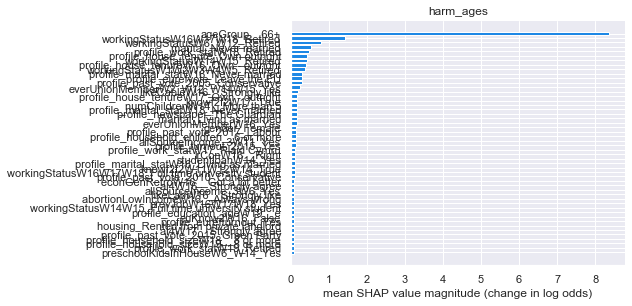

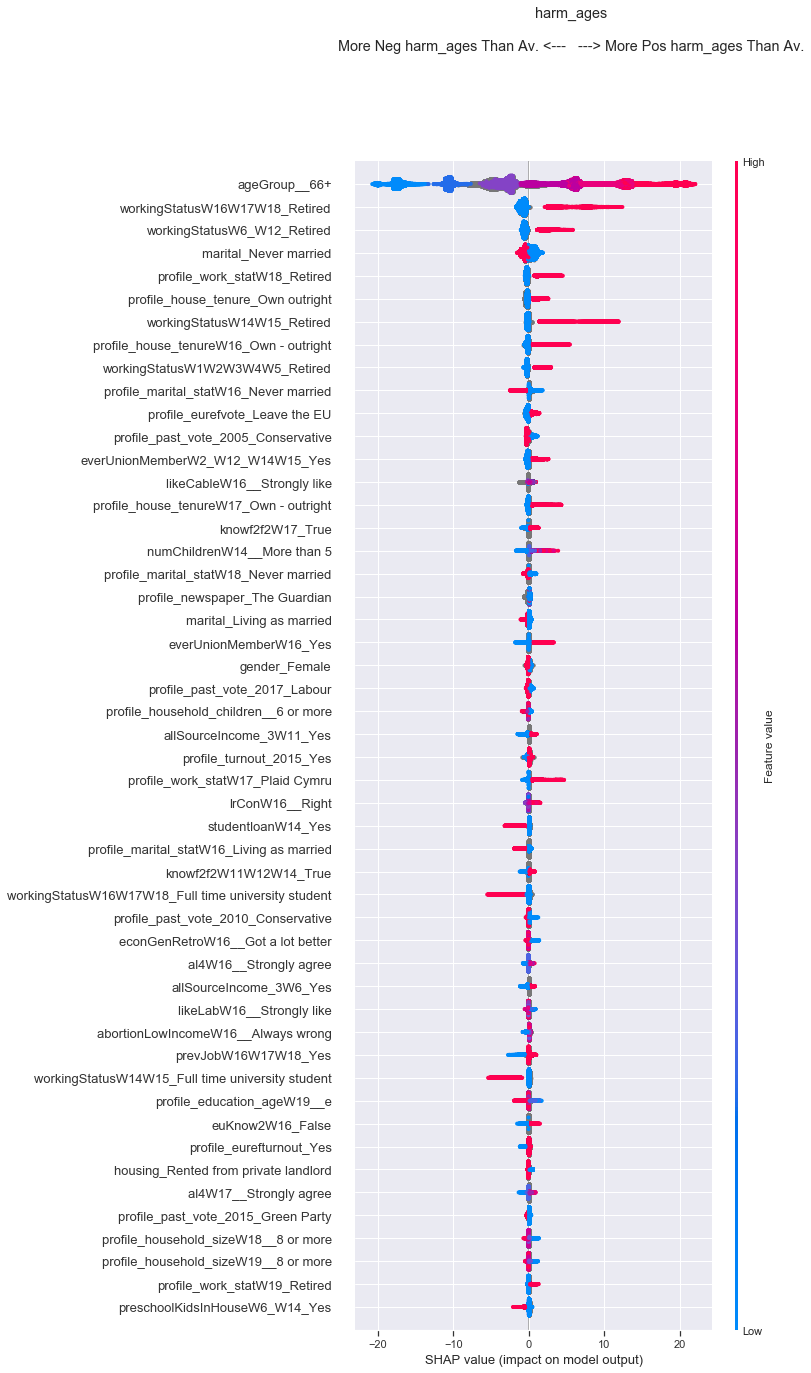

NameError: name 'treatment_dict' is not defined

In [76]:
%%time
# base = "redistSelfW1"

Treatment = "predicted_ages"
var1 = "harm_ages"
BES_reduced_with_na[var1]= Age_at_W1

base = "harm_ages"

# var1 = match(BES_reduced_with_na,base).index[0]

mask = BES_reduced_with_na[var1].notnull()
# mask.loc[mask.index[::2]] = False

age_predictors.append(var1)
df = BES_reduced_with_na[age_predictors][mask].astype('float32')

# df_temp = pd.get_dummies( BES_Panel[match(BES_Panel,"ageGroup|profile_household_children[^W]|edlevel|profile_education_age[^W]|profile_sexualityW10|sexualityW17|profile_religion[^W]").index] )
# df[df_temp.columns] = df_temp

# df[var1] = Age_at_W1[mask]

var_stub = var1

var_list = [var_stub]
var_stub_list = [var_stub]



(explainer, shap_values, train_columns, alg) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)

In [64]:
# %%time
# ## target = D7_8immigEcon
# # wno1 = "8"
# # wno2 = "10"

# base = "redistSelfW1"

# Treatment = base+"with_demog_vars7"


# var1 = match(BES_reduced_with_na,base).index[0]


# mask = BES_reduced_with_na[var1].notnull()
# demog_var = demog_var.replace("edlevel|","")
# demog_var = demog_var.replace("profile_education_age[^W]|","")
# demog_var = demog_var.replace("profile_religion[^W]|","")
# demog_var = demog_var.replace("profile_sexualityW10|sexualityW17|","")
# demog_var = demog_var.replace("ageGroup|","")
# demog_var = demog_var.replace("profile_household_children[^W]|","")
# demog_var = demog_var.replace("Age|","")

# df = BES_reduced_with_na[match(BES_reduced_with_na,demog_var).index][mask].copy()

# df_temp = pd.get_dummies( BES_Panel[match(BES_Panel,"ageGroup|profile_household_children[^W]|edlevel|profile_education_age[^W]|profile_sexualityW10|sexualityW17|profile_religion[^W]").index] )
# df[df_temp.columns] = df_temp

# df[var1] = BES_reduced_with_na[var1][mask]

# var_stub = var1

# var_list = [var_stub]
# var_stub_list = [var_stub]



# (explainer, shap_values, train_columns, alg) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
#            title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
# treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)


In [78]:
z_pred = alg.predict(df[train_columns])
# model.predict(z_test)

In [79]:
z_pred

array([61.709015, 61.18043 , 71.24191 , ..., 33.571175, 30.570265,
       33.969242], dtype=float32)

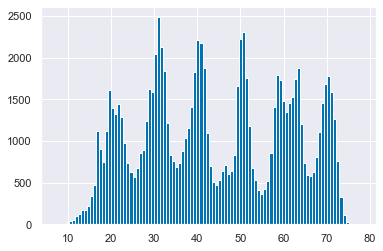

In [81]:
pd.Series(z_pred).hist(bins=100)

In [79]:
Age_at_W1.median()

45.0

In [83]:
mask = BES_reduced_with_na[var1].isnull()
BES_reduced_with_na[var1]= Age_at_W1

In [86]:
BES_reduced_with_na[var1][mask] = z_pred

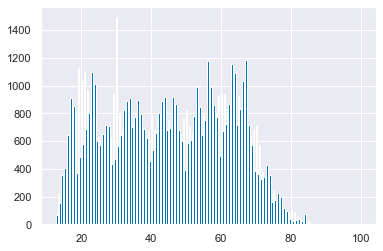

In [89]:
BES_reduced_with_na[var1].hist(bins=200);

In [90]:
BES_reduced_with_na[var1].value_counts()

30.078783    629
23.000000    551
22.000000    544
21.000000    541
24.000000    494
            ... 
37.078847      1
44.415936      1
29.873220      1
26.984664      1
39.403368      1
Name: harm_ages, Length: 42279, dtype: int64

In [82]:
z_pred_all = alg.predict( BES_reduced_with_na[train_columns].astype('float32') )

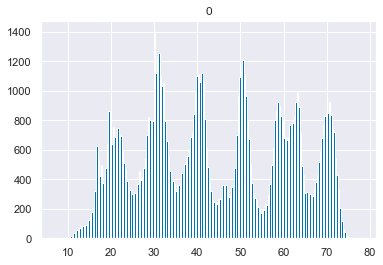

In [83]:
pd.DataFrame(z_pred_all).hist(bins=200);

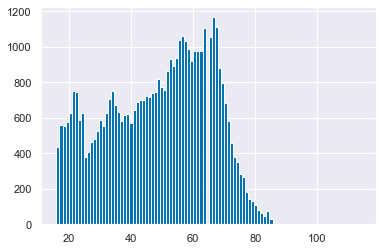

In [84]:
BES_Panel["Age"].hist(bins=100)

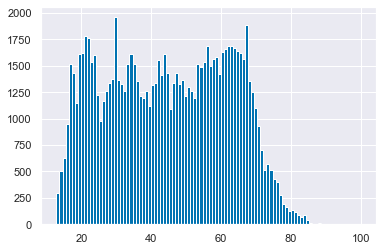

In [96]:
BES_reduced_with_na[var1].hist(bins=100);

In [86]:
Age_at_W1 = ageW_vars_matched.mean(axis=1)

Age_at_W1_missing_values = Age_at_W1.copy()
mask = Age_at_W1.isnull()
Age_at_W1[mask]= z_pred_all[mask]
Age_at_W1.isnull().sum(),Age_at_W1_missing_values.isnull().sum()

Age_at_W1_rounded = Age_at_W1.round()
Age_at_W1 = Age_at_W1 + popt[0]
Age_at_W2 = Age_at_W1 + popt[1]
Age_at_W3 = Age_at_W1 + popt[2]
Age_at_W4 = Age_at_W1 + popt[3]
Age_at_W5 = Age_at_W1 + popt[4]
Age_at_W6 = Age_at_W1 + popt[5]
Age_at_W7 = Age_at_W1 + popt[6]
Age_at_W8 = Age_at_W1 + popt[7]
Age_at_W9 = Age_at_W1 + popt[8]
Age_at_W10 = Age_at_W1 + popt[9]
Age_at_W11 = Age_at_W1 + popt[10]
Age_at_W12 = Age_at_W1 + popt[11]
Age_at_W13 = Age_at_W1 + popt[12]
Age_at_W14 = Age_at_W1 + popt[13]
Age_at_W15 = Age_at_W1 + popt[14]
Age_at_W16 = Age_at_W1 + popt[15]
Age_at_W17 = Age_at_W1 + popt[16]
Age_at_W18 = Age_at_W1 + popt[17]
Age_at_W19 = Age_at_W1 + popt[18]



In [87]:
# pd.cut(Age_at_W1, bins = [ 18, 25,35,45,55,65])
standard_age_groups = pd.IntervalIndex.from_arrays([0, 18, 26,36,46,56,66], [17, 25, 35, 45, 55, 65, 120], closed = 'both')
standardAgeGroup_at_W1 = pd.cut(Age_at_W1_rounded, standard_age_groups, labels = BES_Panel["ageGroup"].cat.categories)
standardAgeGroup_at_W1.cat.rename_categories(BES_Panel["ageGroup"].cat.categories, inplace=True)
standardAgeGroup_at_W1.value_counts().sort_index()

Under 18     5248
18-25       13550
26-35       15991
36-45       15485
46-55       15316
56-65       18576
66+         12840
dtype: int64

In [88]:
# equal_length_age_groups = pd.IntervalIndex.from_arrays([13, 18, 26,36,46,56,66], [17, 25, 35, 45, 55, 65, 120], closed = 'both')
equalLengthAgeGroup_at_W1 = pd.cut(Age_at_W1_rounded, range(10,111,5) )
# standardAgeGroup_at_W1.cat.rename_categories(BES_Panel["ageGroup"].cat.categories, inplace=True)
equalLengthAgeGroup_at_W1.value_counts().sort_index()

(10, 15]      2044
(15, 20]      8323
(20, 25]      8431
(25, 30]      7773
(30, 35]      8218
(35, 40]      7198
(40, 45]      8287
(45, 50]      7288
(50, 55]      8028
(55, 60]      9138
(60, 65]      9438
(65, 70]      7889
(70, 75]      3285
(75, 80]      1228
(80, 85]       402
(85, 90]        28
(90, 95]         6
(95, 100]        2
(100, 105]       0
(105, 110]       0
dtype: int64

In [89]:
Age_at_W1_rounded.min()

12.0

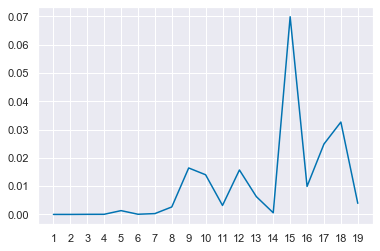

In [90]:
frac_diff_between_emptiest_fullest_bin = []
q_values = range(1,20)
for q in q_values:
    x = pd.qcut(Age_at_W1,q=q, precision=0).value_counts().sort_index()
    (x/x.mean()).max(),(x/x.mean()).min()
    frac_diff_between_emptiest_fullest_bin.append( (x/x.mean()).max() - (x/x.mean()).min() )

plt.plot(q_values,frac_diff_between_emptiest_fullest_bin);
plt.xticks(q_values);
# frac_diff_between_emptiest_fullest_bin

# 8 split is best balance between number of categories and flatness of categories


In [91]:
equalisedAgeGroup_at_W1_detailed = pd.qcut(Age_at_W1,q=14, precision=0)
equalisedAgeGroup_at_W1_detailed.value_counts().sort_index()

(11.0, 18.0]     6930
(18.0, 22.0]     6928
(22.0, 27.0]     6929
(27.0, 31.0]     6931
(31.0, 35.0]     6927
(35.0, 40.0]     6929
(40.0, 44.0]     6929
(44.0, 49.0]     6929
(49.0, 54.0]     6929
(54.0, 57.0]     6930
(57.0, 61.0]     6929
(61.0, 65.0]     6928
(65.0, 69.0]     6929
(69.0, 100.0]    6929
dtype: int64

In [92]:
equalisedAgeGroup_at_W1 = pd.qcut(Age_at_W1,q=7, precision=0)
equalisedAgeGroup_at_W1.value_counts().sort_index()

(11.0, 22.0]     13858
(22.0, 31.0]     13860
(31.0, 40.0]     13856
(40.0, 49.0]     13858
(49.0, 57.0]     13859
(57.0, 65.0]     13857
(65.0, 100.0]    13858
dtype: int64

In [ ]:
frac_diff_between_emptiest_fullest_bin = []
q_values = range(1,20)
for q in q_values:
    x = pd.qcut(Age_at_W19,q=q, precision=0).value_counts().sort_index()
    (x/x.mean()).max(),(x/x.mean()).min()
    frac_diff_between_emptiest_fullest_bin.append( (x/x.mean()).max() - (x/x.mean()).min() )

plt.plot(q_values,frac_diff_between_emptiest_fullest_bin);
plt.xticks(q_values);
# frac_diff_between_emptiest_fullest_bin

# 8 split is best balance between number of categories and flatness of categories


In [134]:
# pd.cut(Age_at_W1, bins = [ 18, 25,35,45,55,65])
standard_age_groups = pd.IntervalIndex.from_arrays([0, 18, 26,36,46,56,66], [17, 25, 35, 45, 55, 65, 120], closed = 'both')
standardAgeGroup_at_W19 = pd.cut(Age_at_W19.round(), standard_age_groups, labels = BES_Panel["ageGroup"].cat.categories)
standardAgeGroup_at_W19.cat.rename_categories(BES_Panel["ageGroup"].cat.categories, inplace=True)
standardAgeGroup_at_W19.value_counts().sort_index()

Under 18        0
18-25        8950
26-35       15931
36-45       15988
46-55       15548
56-65       16962
66+         23627
dtype: int64

In [95]:
# equal_length_age_groups = pd.IntervalIndex.from_arrays([13, 18, 26,36,46,56,66], [17, 25, 35, 45, 55, 65, 120], closed = 'both')
equalLengthAgeGroup_at_W19 = pd.cut(Age_at_W19, range(10,111,5) )
# standardAgeGroup_at_W1.cat.rename_categories(BES_Panel["ageGroup"].cat.categories, inplace=True)
equalLengthAgeGroup_at_W19.value_counts().sort_index()


(10, 15]         0
(15, 20]       898
(20, 25]      7554
(25, 30]      8883
(30, 35]      7029
(35, 40]      8588
(40, 45]      7429
(45, 50]      8212
(50, 55]      7324
(55, 60]      7805
(60, 65]      9025
(65, 70]      9310
(70, 75]      8724
(75, 80]      4086
(80, 85]      1543
(85, 90]       513
(90, 95]        75
(95, 100]        5
(100, 105]       2
(105, 110]       1
dtype: int64

In [96]:
equalisedAgeGroup_at_W19 = pd.qcut(Age_at_W19,q=7, precision=0)
equalisedAgeGroup_at_W19.value_counts().sort_index()

(17.0, 28.0]     13858
(28.0, 37.0]     13860
(37.0, 46.0]     13856
(46.0, 55.0]     13858
(55.0, 63.0]     13859
(63.0, 71.0]     13857
(71.0, 106.0]    13858
dtype: int64

In [97]:
equalisedAgeGroup_at_W19_detailed = pd.qcut(Age_at_W19,q=14, precision=0)
equalisedAgeGroup_at_W19_detailed.value_counts().sort_index()

(17.0, 24.0]     6930
(24.0, 28.0]     6928
(28.0, 33.0]     6929
(33.0, 37.0]     6931
(37.0, 41.0]     6927
(41.0, 46.0]     6929
(46.0, 50.0]     6929
(50.0, 55.0]     6929
(55.0, 59.0]     6929
(59.0, 63.0]     6930
(63.0, 67.0]     6929
(67.0, 71.0]     6928
(71.0, 75.0]     6929
(75.0, 106.0]    6929
dtype: int64

In [136]:
pan_dataset_ages = pd.concat([
                              Age_at_W1_rounded,
                              Age_at_W1,
                              Age_at_W2,
                              Age_at_W3,
                              Age_at_W4,
                              Age_at_W5,
                              Age_at_W6,
                              Age_at_W7,
                              Age_at_W8,
                              Age_at_W9,
                              Age_at_W10,
                              Age_at_W11,
                              Age_at_W12,
                              Age_at_W13,
                              Age_at_W14,
                              Age_at_W15,
                              Age_at_W16,
                              Age_at_W17,
                              Age_at_W18,
                              Age_at_W19,
                              standardAgeGroup_at_W1,
                              equalisedAgeGroup_at_W1,
                              equalisedAgeGroup_at_W1_detailed,
                              equalLengthAgeGroup_at_W1,
                              standardAgeGroup_at_W19,
                              equalisedAgeGroup_at_W19,
                              equalisedAgeGroup_at_W19_detailed,
                              equalLengthAgeGroup_at_W19,                              
                              pd.Series(z_pred_all,index=BES_Panel.index),Age_at_W1_missing_values]
                              ,axis=1)

pan_dataset_ages.columns = ["Age_at_W1_rounded",
                            "Age_at_W1","Age_at_W2","Age_at_W3","Age_at_W4","Age_at_W5","Age_at_W6",
                            "Age_at_W7","Age_at_W8","Age_at_W9","Age_at_W10",
                            "Age_at_W11","Age_at_W12","Age_at_W13","Age_at_W14",
                            "Age_at_W15","Age_at_W16","Age_at_W17","Age_at_W18","Age_at_W19",
                            "standardAgeGroup_at_W1","equalisedAgeGroup_at_W1",
                            "equalisedAgeGroup_at_W1_detailed","equalLengthAgeGroup_at_W1",
                            "standardAgeGroup_at_W19","equalisedAgeGroup_at_W19",
                            "equalisedAgeGroup_at_W19_detailed","equalLengthAgeGroup_at_W19",
                            "rough_predictions","Age_at_W1_missing_values"]
pan_dataset_ages["Age_at_W1_rounded"] = pan_dataset_ages["Age_at_W1_rounded"].astype('int8')
pan_dataset_ages.index = BES_Panel.index

# pan_dataset_ages["id"] = BES_Panel["id"].astype('int')

# pan_dataset_ages.to_csv(    BES_small_data_files + "pan_dataset_ages"+".csv", index=False)
# pan_dataset_ages.to_msgpack(BES_small_data_files + "pan_dataset_ages"+".msgpack")

In [138]:
pan_dataset_ages.shape, BES_Panel.shape

((97006, 30), (97006, 8079))

In [139]:
pan_dataset_ages.to_csv(    BES_small_data_files + "pan_dataset_ages"+".csv", index=False)

In [140]:
pan_dataset_ages.to_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')

In [156]:
pan_dataset_ages

,id,Age_at_W1,Age_at_W1_rounded,Age_at_W7,Age_at_W8,Age_at_W9,Age_at_W11,Age_at_W12,Age_at_W13,Age_at_W14,...,standardAgeGroup_at_W1,equalisedAgeGroup_at_W1,equalisedAgeGroup_at_W1_detailed,equalLengthAgeGroup_at_W1,standardAgeGroup_at_W19,equalisedAgeGroup_at_W19,equalisedAgeGroup_at_W19_detailed,equalLengthAgeGroup_at_W19,rough_predictions,Age_at_W1_missing_values
0,16208,60.413227,60,62.214989,62.297593,62.357362,62.721667,62.968143,63.054837,63.993884,...,56-65,"(55.0, 64.0]","(60.0, 64.0]","(55, 60]",NaN,"(60.0, 69.0]","(65.0, 69.0]","(65, 70]",63.013264,60.413227
1,16546,58.251871,58,60.053632,60.136236,60.196005,60.560310,60.806786,60.893481,61.832527,...,56-65,"(55.0, 64.0]","(55.0, 60.0]","(55, 60]",56-65,"(60.0, 69.0]","(60.0, 65.0]","(60, 65]",62.523399,58.251871
2,66250,67.617856,68,69.419617,69.502222,69.561991,69.926295,70.172772,70.259466,71.198512,...,66+,"(64.0, 100.0]","(64.0, 68.0]","(65, 70]",66+,"(69.0, 105.0]","(69.0, 74.0]","(70, 75]",66.589882,67.617856
3,32741,53.445014,53,55.246775,55.329380,55.389149,55.753453,55.999930,56.086624,57.025670,...,46-55,"(45.0, 55.0]","(50.0, 55.0]","(50, 55]",56-65,"(50.0, 60.0]","(55.0, 60.0]","(55, 60]",48.161797,53.445014
4,70863,64.153401,64,65.955163,66.037767,66.097536,66.461841,66.708317,66.795011,67.734058,...,56-65,"(64.0, 100.0]","(64.0, 68.0]","(60, 65]",66+,"(69.0, 105.0]","(69.0, 74.0]","(65, 70]",54.507549,64.153401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97153,1306,32.000000,32,33.801761,33.884366,33.944135,34.308439,34.554916,34.641610,35.580656,...,26-35,"(24.0, 34.0]","(30.0, 34.0]","(30, 35]",36-45,"(29.0, 40.0]","(35.0, 40.0]","(35, 40]",43.433151,32.000000
97154,40381,44.092435,44,45.894196,45.976800,46.036569,46.400874,46.647350,46.734044,47.673091,...,36-45,"(34.0, 45.0]","(40.0, 45.0]","(40, 45]",46-55,"(40.0, 50.0]","(45.0, 50.0]","(45, 50]",41.919456,44.092435
97155,54315,17.271241,17,19.073002,19.155607,19.215375,19.579680,19.826156,19.912851,20.851897,...,Under 18,"(12.0, 24.0]","(12.0, 20.0]","(15, 20]",18-25,"(17.0, 29.0]","(17.0, 25.0]","(20, 25]",18.067436,17.271241
97156,26708,33.000000,33,34.801761,34.884366,34.944135,35.308439,35.554916,35.641610,36.580656,...,26-35,"(24.0, 34.0]","(30.0, 34.0]","(30, 35]",36-45,"(29.0, 40.0]","(35.0, 40.0]","(35, 40]",40.060276,33.000000


In [141]:
(pan_dataset_ages["Age_at_W7"]<18).sum()

2699